<a href="https://colab.research.google.com/github/shaozw/odsc-2023-llm-alignment/blob/main/ODSC_sawyer_1_instruction_ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Supervised Fine-tune our LLM

## Installs

In [ ]:
!pip install datasets transformers[torch] wandb einops peft accelerate bitsandbytes

# Keys

In [ ]:
import huggingface_hub, os
huggingface_hub.login(token=os.environ['HF_API_KEY'])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Imports and Downloads

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, pipeline, \
                         AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from datasets import load_dataset, Dataset
import torch
import json
from tqdm import tqdm

SEED=42

In [ ]:
dataset = load_dataset("lmsys/lmsys-chat-1m", split='train').shuffle(SEED)
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Dataset({
    features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
    num_rows: 1000000
})

# Pre-Process Data

In [ ]:
df = pd.DataFrame(dataset)
df['conversation'] = df['conversation'].apply(json.dumps)
df

In [ ]:
# rows with 'apologize' in conversation or 'ai language model' in conversation
df.query('"apologize" not in conversation and "ai language model" not in conversation')


In [ ]:
# some filtering of data
dataset = dataset.filter(
    lambda item: item[
        'language'] == 'English' and item[
            'redacted'] == False and item[
                'turn'] <= 2 and len(str(item['conversation'])) < 1000 and \
                                         'ai language model' not in str(item['conversation']).lower()
    )
dataset

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Dataset({
    features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
    num_rows: 197068
})

In [ ]:
# Our base foundation model
MODEL = 'bigscience/bloom-560m'
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
# We are going to be adding some tokens to our vocabulary
SYSTEM_KEY = "<system>"
QUERY_KEY = "<human>"
RESPONSE_KEY = "<bot>"
STOP_KEY = "<stop>"

ADDING_TOKENS = True

In [ ]:
if ADDING_TOKENS:
    tokenizer.add_special_tokens({"additional_special_tokens": [SYSTEM_KEY, QUERY_KEY, RESPONSE_KEY, STOP_KEY]})

MAX_LENGTH = 512
def preprocess(batch):
    modified_texts =[]
    for convo in batch['conversation']:
        prompt = f'{SYSTEM_KEY}You are a helpful AI assistant'
        for turn in convo:
            role = QUERY_KEY if turn['role'] == 'user' else RESPONSE_KEY
            prompt += f'{role}{turn["content"]}'
            if role == RESPONSE_KEY:
                prompt += STOP_KEY
        modified_texts.append(prompt)

    responses = tokenizer(modified_texts, truncation=True, max_length=MAX_LENGTH)
    return responses

dataset = dataset.map(
    preprocess, batched=True, batch_size=256
)


Map:   0%|          | 0/197068 [00:00<?, ? examples/s]

In [ ]:
stop = tokenizer.encode(STOP_KEY)[0]

# simple sanity check to make sure no conversations were too long as not have a single stop token in them
dataset = dataset.filter(lambda e: stop in e['input_ids'], batched=False)

Filter:   0%|          | 0/197068 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted', 'input_ids', 'attention_mask'],
    num_rows: 197037
})

In [ ]:
def print_trainable_parameters(model, verbose=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if verbose:
                print(f'{_}: {param.numel()}')
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL, trust_remote_code=True,
    device_map={'': 0})

model.config.pad_token = tokenizer.pad_token
model.config.eos_token = tokenizer.eos_token

if ADDING_TOKENS:
    model.resize_token_embeddings(len(tokenizer))

print_trainable_parameters(model)

trainable params: 559013888 || all params: 559013888 || trainable%: 100.0


In [ ]:
model

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250684, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (

In [ ]:
stop_id = tokenizer.encode(STOP_KEY)[0]
old_stop = model.transformer.word_embeddings._parameters['weight'][stop_id]
old_stop

tensor([-0.0028, -0.0038, -0.0012,  ..., -0.0252,  0.0013,  0.0012],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
stop_id

250682

In [ ]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=16,
    bias="none",
    target_modules=['query_key_value', 'lm_head'],
    task_type="CAUSAL_LM",
    modules_to_save=["word_embeddings", "word_embeddings_layernorm"]
)

model = get_peft_model(model, peft_config)

In [ ]:
model.print_trainable_parameters() # peft models have that above function built in as a method

trainable params: 519,005,120 || all params: 821,316,544 || trainable%: 63.19185018145696


In [ ]:
print_trainable_parameters(model, verbose=True)  # I like mine better because it's verbose :)

base_model.model.transformer.word_embeddings.original_module.weight: 256700416
base_model.model.transformer.word_embeddings.modules_to_save.default.weight: 256700416
base_model.model.transformer.word_embeddings_layernorm.original_module.weight: 1024
base_model.model.transformer.word_embeddings_layernorm.original_module.bias: 1024
base_model.model.transformer.word_embeddings_layernorm.modules_to_save.default.weight: 1024
base_model.model.transformer.word_embeddings_layernorm.modules_to_save.default.bias: 1024
base_model.model.transformer.h.0.self_attention.query_key_value.lora_A.default.weight: 16384
base_model.model.transformer.h.0.self_attention.query_key_value.lora_B.default.weight: 49152
base_model.model.transformer.h.1.self_attention.query_key_value.lora_A.default.weight: 16384
base_model.model.transformer.h.1.self_attention.query_key_value.lora_B.default.weight: 49152
base_model.model.transformer.h.2.self_attention.query_key_value.lora_A.default.weight: 16384
base_model.model.tran

In [ ]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): ModulesToSaveWrapper(
          (original_module): Embedding(250684, 1024)
          (modules_to_save): ModuleDict(
            (default): Embedding(250684, 1024)
          )
        )
        (word_embeddings_layernorm): ModulesToSaveWrapper(
          (original_module): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (modules_to_save): ModuleDict(
            (default): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          )
        )
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): Linear(
                in_features=1024, out_features=3072, bias=True
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace

In [ ]:
# some buggy behavior, making sure the params I want to train are turned on and ones I don't are off
for name, param in model.named_parameters():
    if 'original_module' in name and param.requires_grad:
        print(f'Turning off {name}')
        param.requires_grad = False

print_trainable_parameters(model, verbose=True)


Turning off base_model.model.transformer.word_embeddings.original_module.weight
Turning off base_model.model.transformer.word_embeddings_layernorm.original_module.weight
Turning off base_model.model.transformer.word_embeddings_layernorm.original_module.bias
base_model.model.transformer.word_embeddings.modules_to_save.default.weight: 256700416
base_model.model.transformer.word_embeddings_layernorm.modules_to_save.default.weight: 1024
base_model.model.transformer.word_embeddings_layernorm.modules_to_save.default.bias: 1024
base_model.model.transformer.h.0.self_attention.query_key_value.lora_A.default.weight: 16384
base_model.model.transformer.h.0.self_attention.query_key_value.lora_B.default.weight: 49152
base_model.model.transformer.h.1.self_attention.query_key_value.lora_A.default.weight: 16384
base_model.model.transformer.h.1.self_attention.query_key_value.lora_B.default.weight: 49152
base_model.model.transformer.h.2.self_attention.query_key_value.lora_A.default.weight: 16384
base_mod

In [ ]:
dataset = dataset.train_test_split(test_size=0.1, seed=SEED)  # split our dataset

In [ ]:
# example
print(tokenizer.decode(dataset['train'][0]['input_ids'], skip_special_tokens=False))

<system>You are a helpful AI assistant<human>I'm inside a coffee shop, there's a glass door with "push" written on in with mirror font. I want to go out, do I have to "PULL" or "PUSH" the door ?<bot>If the door is heavy, you will have to "PUSH" the door, if the door is light, you will have to "PULL" the door.<stop>


In [ ]:
print_trainable_parameters(model)

trainable params: 262302656 || all params: 821316544 || trainable%: 31.93685283904375


In [ ]:
# custom data collator to only calculate losses for bot responses, not for the human/system prompts
import numpy as np

class DataCollatorForCompletionOnlyLM(DataCollatorForLanguageModeling):
    def torch_call(self, examples):
        batch = super().torch_call(examples)

        response_token_ids = self.tokenizer.encode(RESPONSE_KEY)

        labels = batch["input_ids"].clone()

        for i in range(len(examples)):  # even if there are two turns, we are only training on final bot step

            response_token_ids_start_idx = None
            for idx in np.where(batch["labels"][i] == response_token_ids[0])[0]:
                response_token_ids_start_idx = idx

            if response_token_ids_start_idx is None:
                raise RuntimeError(
                    f'Could not find response key {response_token_ids} in token IDs {batch["labels"][i]}'
                )

            response_token_ids_end_idx = response_token_ids_start_idx + 1

            # Make pytorch loss function ignore all tokens up through the end of the response key
            labels[i, :response_token_ids_end_idx] = -100

        batch["labels"] = labels

        return batch

data_collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer, mlm=False,
    return_tensors="pt", pad_to_multiple_of=8
)


In [ ]:
dataset = dataset.remove_columns(['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'])

dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 177333
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 19704
    })
})

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

dc = data_collator([dataset['train'][0], dataset['train'][1], dataset['train'][2]])
dc

You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[     2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2,      2,      2,      2,      2,      2,      2,
              2,      2,      2, 250680,   5448,   1306,    267,  66799,  75299,
         103800, 250681,  10203,  14652,    267,  71495,  33922,     15,  20242,
            26

In [ ]:
tokenizer.batch_decode(dc['input_ids'], skip_special_tokens=False)

['</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><system>You are a helpful AI assistant<human>I\'m inside a coffee shop, there\'s a glass door with "push" written on in with mirror font. I want to go out, do I have to "PULL" or "PUSH" the door ?<bot>If the door is heavy, you will have to "PUSH" the door, if the door is light, you will have to "PULL" the door.<stop>',
 '</s></s></s></s></s></s><system>You are a helpful AI assistant<human>I want you to act as an academician. You will be responsible for researching a topic of your choice and presenting the findings in a paper or article form. Your task is to identify reliable sources, organize the material in a well-str

<Axes: >

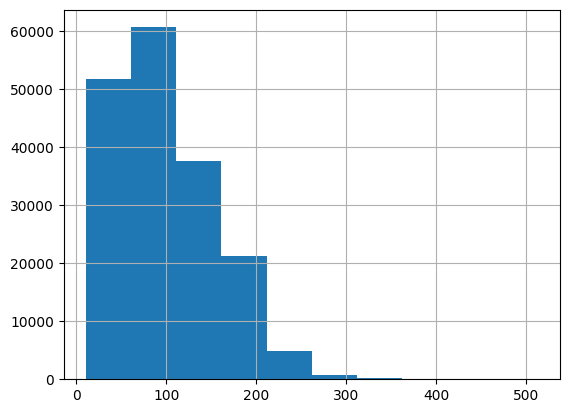

In [ ]:
# token length disribution
pd.Series(list(map(lambda x: len(x), dataset['train']['input_ids']))).hist()

In [ ]:
import wandb
# Set up Weights and Biases integration
wandb.init(project="odsc-sawyer-sft")

dataset.set_format('torch')
dataset

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 177333
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 19704
    })
})

In [ ]:
from transformers import TrainingArguments, Trainer

username, repo_name = 'profoz', 'odsc-sawyer-sft'

training_args = TrainingArguments(
    output_dir="./sawyer",  # The output directory
    overwrite_output_dir=True,  # overwrite the content of the output directory
    num_train_epochs=1,  # number of training epochs
    per_device_train_batch_size=2,  # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    gradient_accumulation_steps=32,  # steps for gradient accumulation
    learning_rate=3e-4,
    logging_steps=10,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    warmup_ratio=0.2,
    report_to="all",
    seed=SEED,
    hub_model_id=f"{username}/{repo_name}"
    # if you need memory improvements
    # fp16=True if device.type == 'cuda' else False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=data_collator
)

trainer.evaluate()

{'eval_loss': 3.3410584926605225,
 'eval_runtime': 1360.2545,
 'eval_samples_per_second': 14.486,
 'eval_steps_per_second': 3.621}

In [ ]:
torch.cuda.empty_cache()

trainer.train()

Epoch,Training Loss,Validation Loss
0,1.544300,1.551447


TrainOutput(global_step=2770, training_loss=1.6887144412374668, metrics={'train_runtime': 25681.466, 'train_samples_per_second': 6.905, 'train_steps_per_second': 0.108, 'total_flos': 4.388056067202662e+16, 'train_loss': 1.6887144412374668, 'epoch': 1.0})

In [ ]:
model.base_model.transformer.word_embeddings

ModulesToSaveWrapper(
  (original_module): Embedding(250684, 1024)
  (modules_to_save): ModuleDict(
    (default): Embedding(250684, 1024)
  )
)

In [ ]:
model.transformer.word_embeddings.modules_to_save['default']._parameters['weight']

Parameter containing:
tensor([[-0.0099, -0.0048, -0.0111,  ..., -0.0426,  0.0099,  0.0212],
        [-0.0004, -0.0108,  0.0131,  ..., -0.0218, -0.0005, -0.0114],
        [ 0.0063,  0.0224, -0.0060,  ..., -0.0487, -0.0058,  0.0193],
        ...,
        [-0.0044, -0.0126, -0.0058,  ..., -0.0277,  0.0027,  0.0068],
        [ 0.0103,  0.0050, -0.0155,  ..., -0.0329,  0.0011,  0.0065],
        [ 0.0035, -0.0064, -0.0004,  ..., -0.0262,  0.0164, -0.0017]],
       device='cuda:0', requires_grad=True)

In [ ]:
# # Push model and tokenizer to Hugging Face Hub
trainer.push_to_hub(f"{username}/{repo_name}")

# trainer.model.push_to_hub(f"{username}/{repo_name}")
tokenizer.push_to_hub(f"{username}/{repo_name}")


CommitInfo(commit_url='https://huggingface.co/profoz/odsc-sawyer-sft/commit/787fd003049c236aa386c4b95042ed17f8a91246', commit_message='Upload tokenizer', commit_description='', oid='787fd003049c236aa386c4b95042ed17f8a91246', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# n days later..

username, repo_name = 'profoz', 'odsc-sawyer-sft'

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

config = PeftConfig.from_pretrained("profoz/odsc-sawyer-sft")
loaded_tokenizer = AutoTokenizer.from_pretrained(f"{username}/{repo_name}")
loaded_model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m")
loaded_model.resize_token_embeddings(len(loaded_tokenizer))

loaded_model = PeftModel.from_pretrained(loaded_model, "profoz/odsc-sawyer-sft")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import torch
input_ids = loaded_tokenizer.encode(
    "<system>You are a helpful AI assistant<human>Whats 1+1?<bot>",
    return_tensors='pt').to(loaded_model.device)

outputs = loaded_model.generate(
    input_ids=input_ids,
    return_dict_in_generate=True, output_scores=True,
    eos_token_id=loaded_tokenizer.encode('<stop>')[0],
    max_new_tokens=32,
    do_sample=True,
    num_return_sequences=1
    )
responses = loaded_tokenizer.batch_decode(outputs.sequences, skip_special_tokens=False)
print(responses)

transition_scores = loaded_model.compute_transition_scores(
    outputs.sequences, [s.to(dtype=torch.float32) for s in outputs.scores],
    normalize_logits=True
)


['<system>You are a helpful AI assistant<human>Whats 1+1?<bot>Sure! 1 + 1 = 2.<stop>']
